<img src="./images/SMILESX_logo.png" alt="drawing" width="300" align="left"/>

# Welcome to the SMILES-X tutorial!

In this brief tutorial we cover the basics of the SMILES-X package.
Here we show how to train, extract and use trained SMILES-X models. More detailed information on the package implementation and fundamentals can be found in the documentation.

The main body of the SMILES-X is contained in the `main.py`, which we need to import.\We will also need to import the library that is going to be used for data reading and preprocessing. Here we use `pandas` to work with the `./data/example_data.csv` data file.

In [23]:
import pandas as pd
import numpy as np

from SMILESX import main, loadmodel, generative_main, generation, trainutils

%load_ext autoreload
%aimport SMILESX
%autoreload 2
%matplotlib inline

%load_ext line_profiler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [2]:
# Define data folder and extension
data_path = "./data/example_data.csv"

In [3]:
# Provide data information
data_name = 'Test'
data_label = 'Test label' # will show on plots
data_units = 'units' # will show on plots

In [4]:
# Load the data
data = pd.read_csv(data_path)

## Data format

The data format is not critical as long as it can be shaped into a numpy array, and provides the following information:
- SMILES
- ground true values (experimental or theoretical, mean or median)


It can **optionally** include:
- minimum and maximum values (error bars will represent the range of values)
- standard deviation (error bars will represent one standard deviation)
- additional numeric values

In [5]:
data.head(10)

,smiles1,smiles2,median,min,max,extra_1,extra_2,extra_3
0,CC(O)(CO)C(O)CO,*CC(*)CC(C)C,-68.75,-129.0,-23.0,150,0.343,4.521
1,OC1COC(O)C(O)C1O,*CC(*)CC(C)(C)C,-18.00,-34.0,-7.0,22,0.729,5.065
2,OCC1(O)OCC(O)C(O)C1O,*CC(C)C(*)(C)C,-43.00,-43.0,-43.0,85,0.439,3.196
3,O=CC(O)C(O)C(O)C(O)CO,*/C=C/COCC*,-52.25,-53.0,-51.5,74,0.060,4.112
4,OC1C2COC(O2)C(O)C1O,*CC(*)CCCC,-51.00,-59.6,-23.0,75,0.398,8.834
5,OCC1OC(O)C(O)C(O)C1O,*C*,32.00,32.0,32.0,147,0.738,1.289
6,CCCCO,*CCCCCCCC(*)C,-31.00,-31.0,-31.0,42,0.182,6.072
7,CCC(C)O,*CC(*)CCCCCCC,-47.00,-47.0,-47.0,56,0.175,6.032
8,CCO,*CC(*)(C)C,-73.00,-80.5,-3.0,235,0.532,6.912
9,OCCO,*CC(*)(C)CC,-5.00,-5.0,-5.0,65,0.532,5.962


Our example data file consists of real polymeric SMILES, and is accompanied by fake median, mininum and maximum values. \
It also contains auxiliary data `extra_1`, `extra_2`, `extra_3`.

## Hyperparameters optimization

First, we have to optimize the architecture shape as well as its hyperparameters. For this, we have to define the hyperparameters space. In the SMILES-X, the hyperparameters that can be optimized are:

**Geometry-related hyperparameters**
- Embedding size\
    The dimensionality of the embedding
- LSTM layer size\
    Number of units in the LSTM layer. As we use bidirectional LSTM, this number is internally multiplied by two during the run.
- Time-distributed (TD) dense layer size\
    Number of units in the TD dense layer

**Training-related hyperparameters**
- Batch size
- Learning rate
   
For each of the hyperparameter the bounds are defined as a **list of discrete values**.\
For the learning rate, we give a range of powers of 10.\
The typical bounds that can be used:

    embed_bounds = [8, 16, 32, 64, 128, 256, 512]
    lstm_bounds = [8, 16, 32, 64, 128, 256, 512]
    tdense_bounds = [8, 16, 32, 64, 128, 256, 512]
    bs_bounds = [8, 16, 32, 64, 128, 256, 512]
    lr_bounds = [2, 2.1, 2.2, ..., 3.8, 3.9]
  
Note, that for the sake of demonstration, we run the code with narrower bounds:

In [9]:
# Defining the hyperparameters' bounds
embed_bounds = [8, 16] # embedding size
lstm_bounds = [8, 16] # number of units in the LSTM layer
tdense_bounds = [8, 16] # number of units in the dense layer
bs_bounds = [64, 128] # batch size
lr_bounds = [2., 2.5, 3., 3.5] # learning rate

Depending on the user request, hyperparameters optimization can be performed in single- or two-steps fashion.

Single-step optimizations implies optimization of all the given hyperparameters simultaneously via Bayesian optimization. Bayesian optimization is activate by setting `bayopt_mode='on'`.

For the two-step optimization, SMILES-X implements zero-cost optimization of geometry-related hyperparameters. This allows to scan through the whole set of possible combinations of `[embed_bounds, lstm_bounds, tdense_bounds]` in a relatively short period of time. Trainless geometry optimization can be enable by setting `geomopt_mode='on'`. The remaining training-related hyperparameters are then optimized via Bayesian optimization, if it is activated. As trainless geometry optimization provides good and stable results, the two-step optimization is set by default.

Hyperparameters optimization can be skipped altogether by setting both `bayopt_mode` and `geomopt_mode` to `'off'`. In this case, the user should provide referense values of the hyperparameters (`embed_ref`, `lstm_ref`, `dense_ref`, `bs_ref` and `lr_ref`). In case where no reference values are provided, default values are used. 

Note, that only the hyperparameters optimization will only optimize those hyperparameters, which have defined bounds, in accordance with the requested modes. The remaining onse will be set either to the user-defined or to the default values. For instance, it is possible to optimize only a part of geometry, or only the learning rate.


## Training

The SMILES-X training is performed by calling the `main` function. Here we define the inputs, optimization parameters, training parameters (number of epochs, number of independent runs, number of folds in k-fold cross validation, learning rate schedule and so on) and GPU setup.

This will create a new path in the `./outputs` directory, corresponding to the indicated `data_name`. All the models, as well as auxiliary data such as scalers and logs, are stored there.

Now you are ready to run the first SMILES-X model training!

In [10]:
main.main(data_smiles=data[['smiles1']], # data[['smiles1','smiles2']], # SMILES input
          data_prop=data[['median']], # Property of interest
          data_err=data[['min', 'max']], # Error on the property
          data_name=data_name,
          data_units=data_units,
          data_label=data_label,
          smiles_concat=False, # True if the input is a pair of SMILES
          geomopt_mode='on', # Zero-cost geometry optimization
          bayopt_mode='on', # Bayesian optimization
          train_mode='on', # Train
          model_type = 'regression', # or 'classification'
          scale_output = True,
          bs_bounds=bs_bounds,
          lr_bounds=lr_bounds,
          embed_bounds=embed_bounds,
          lstm_bounds=lstm_bounds,
          tdense_bounds=tdense_bounds,
          k_fold_number=2, # Number of cross-validation splits
          n_runs=2,# Number of runs per fold
          check_smiles=True, # Verify SMILES validity via RDKit
          augmentation=False, # Augment the data or not
          bayopt_n_rounds=2,
          bayopt_n_epochs=5,
          bayopt_n_runs=2,
          n_gpus=1,
          n_epochs=10,
          log_verbose=True, # To send print outs both to the file and console
          train_verbose=True) # Show model training progress)

2023-08-08 14:38:55:   ************************
2023-08-08 14:38:55:   ***SMILES-X starts...***
2023-08-08 14:38:55:   ************************
2023-08-08 14:38:55:   
2023-08-08 14:38:55:   
2023-08-08 14:38:55:   The SMILES-X logs can be found in the ./outputs/Test/Can/Train/Train_2023-08-08_14:38:55.log file.
2023-08-08 14:38:55:   
2023-08-08 14:38:55:   ***Configuration parameters:***
2023-08-08 14:38:55:   
2023-08-08 14:38:55:   data =
    SMILES                   Test label    Minimum    Maximum
--  ---------------------  ------------  ---------  ---------
 0  CC(O)(CO)C(O)CO              -68.75     -129        -23
 1  OC1COC(O)C(O)C1O             -18         -34         -7
 2  OCC1(O)OCC(O)C(O)C1O         -43         -43        -43
 3  O=CC(O)C(O)C(O)C(O)CO        -52.25      -53        -51.5
 4  OC1C2COC(O2)C(O)C1O          -51         -59.6      -23
2023-08-08 14:38:55:   data_name = 'Test'
2023-08-08 14:38:55:   data_units = 'units'
2023-08-08 14:38:55:   data_label = 'Test

The output data is organized in the following way:

```
./outputs
└───Test
    └───Augm
        └───Train
            │   Scores_Folds.csv # RMSE, MAE, R2 scores per fold
            │   Scores_Final.csv # Final out-of-sample RMSE, MAE, R2 scores
            │   Predictions.csv # Out-of-samples predictions for each SMILES
            │   Train_yyyy-mm-dd_hh:mm:ss.log # Logs
            │
            └───Plots # Prediction vs Observation plots per fold and final out-of-sample
            │   └───Prediction_vs_Observation
            │   │   │   Test_PredvsTrue_Plot.png
            │   │   │
            │   │   └───Runs
            │   │   │       Test_PredvsTrue_Plot_Fold_0_Run_0.png
            │   │   │       Test_PredvsTrue_Plot_Fold_0_Run_1.png
            │   │   │       Test_PredvsTrue_Plot_Fold_0_Run_2.png
            │   │   │       Test_PredvsTrue_Plot_Fold_1_Run_0.png
            │   │   │       ...
            │   │   │
            │   │   └───Folds
            │   │           Test_PredvsTrue_Plot_Fold_0.png
            │   │           Test_PredvsTrue_Plot_Fold_1.png
            │   │           Test_PredvsTrue_Plot_Fold_2.png
            │   │
            │   └───Learning_Curves # Learning curves, one per run
            │           Test_FitHistory_Fold_0_Run_0.png
            │           Test_FitHistory_Fold_0_Run_1.png
            │           Test_FitHistory_Fold_0_Run_2.png
            │           Test_FitHistory_Fold_1_Run_0.png
            │           ...
            │
            └───Models # One per run
            │   │   Test_Model_Fold_0_Run_0.hdf5 
            │   │   Test_Model_Fold_0_Run_1.hdf5 
            │   │   Test_Model_Fold_0_Run_2.hdf5 
            │   │   Test_Model_Fold_1_Run_0.hdf5
            │   │   ...
            │
            └───Other # Auxiliary files
                │   Test_Hyperparameters.csv # Hyperparameters used for training
                │   Test_GeomScores.csv # Geometry optimization scores, sorted
                │   Test_Vocabulary.txt # Vocabulary
                │
                └───Scalers
                    │   Test_Scaler_Extra.pkl # Scaler for additional data input (if `data_extra` is provided)
                    │   Test_Scaler_fold_0.pkl # Scaler for the outputs, one per fold
                    │   Test_Scaler_fold_1.pkl # Scaler for the outputs, one per fold
                    │   Test_Scaler_fold_2.pkl # Scaler for the outputs, one per fold
```
First, `Test` directory is created in `./outputs/`, which corresponds to the provided `data_name`. As the data augmentation has been requested, an `Augm` directory is created whithin `Test` one (otherwise it would be called `Can` for "canonical"). Finally, all the output files related to training are stored within the `Train` directory. 

First of, this is where per-SMILES predictions (`*_Predictions.csv`) and per-fold and final out-of-sample statistics (`*_Scores_Folds.csv` and `*_Scores_Final.csv`) are stored. The following several lines help to access them:

In [6]:
from tabulate import tabulate
predictions = pd.read_csv("./outputs/{0}/Can/Train/{0}_Predictions.csv".format(data_name))
scores_folds = pd.read_csv("./outputs/{0}/Can/Train/{0}_Scores_Folds.csv".format(data_name), header=[0,1,2],index_col=[0])
scores_final = pd.read_csv("./outputs/{0}/Can/Train/{0}_Scores_Final.csv".format(data_name), header=[0,1])

In [7]:
predictions

,SMILES,Test label,Minimum,Maximum,Fold,Mean,Standard deviation
0,CC(O)(CO)C(O)CO,-68.75,-129.0,-23.0,0.0,-2.130749,5.008845
1,OC1COC(O)C(O)C1O,-18.00,-34.0,-7.0,1.0,-56.627008,3.462790
2,OCC1(O)OCC(O)C(O)C1O,-43.00,-43.0,-43.0,0.0,3.461169,4.134171
3,O=CC(O)C(O)C(O)C(O)CO,-52.25,-53.0,-51.5,1.0,-77.654770,0.012115
4,OC1C2COC(O2)C(O)C1O,-51.00,-59.6,-23.0,0.0,0.335941,3.425388
5,OCC1OC(O)C(O)C(O)C1O,32.00,32.0,32.0,1.0,-70.044994,2.457218
6,CCCCO,-31.00,-31.0,-31.0,1.0,-12.394588,5.972232
7,CCC(C)O,-47.00,-47.0,-47.0,1.0,-33.815805,6.997618
8,CCO,-73.00,-80.5,-3.0,0.0,-1.230375,2.273525
9,OCCO,-5.00,-5.0,-5.0,1.0,1.483606,2.438101


In [8]:
scores_folds

Train                                                     \
           RMSE                  MAE            R2-score             
           Mean     Sigma       Mean     Sigma      Mean     Sigma   
Fold                                                                 
0     32.696918  2.177866  29.536102  1.907164 -0.141445  0.152058   
1     20.214729  1.455734  17.615379  2.177607  0.656575  0.049462   

           Valid                                                       \
            RMSE                   MAE             R2-score             
            Mean     Sigma        Mean     Sigma       Mean     Sigma   
Fold                                                                    
0     140.472366  2.592677  111.141308  3.728001  -0.616059  0.059655   
1      75.192531  1.833993   75.155658  1.893450 -99.514076  4.903203   

           Test                                                     
           RMSE                  MAE            R2-score            
           Mean     Sigma       Mean     Sigma      Mean     Sigma  
Fold                                                                
0     51.948806  1.313157  48.940081  1.822327 -1.464566  0.124598  
1     93.219481  1.764272  60.398706  1.655225 -0.424641  0.053926

In [9]:
scores_final

RMSE                  MAE            R2-score          
        Mean     Sigma       Mean     Sigma      Mean     Sigma
0  74.125357  1.145853  54.287439  1.241477 -0.342869  0.041517

## Additional numerical inputs

This time we are going to traing a model with some additional data. These data will be injected in the model at the level between the attention and the output layer. In order to add non-linearity between the additional data, we insert 3 additional dense layers. We do not perform geometry optimization and set the architecture to some reference values. Data augmentation is set to `False`.

In [11]:
main.main(data_smiles=data['smiles1'], # SMILES input
          data_prop=data[['median']], # Property of interest
          data_err=data[['min', 'max']], # Error on the property
          data_extra=data[['extra_1', 'extra_2', 'extra_3']], # Auxiliary input data
          data_name=data_name+'_EXTRA',
          data_units=data_units,
          data_label=data_label,
          geomopt_mode='off', # Zero-cost geometry optimization
          bayopt_mode='off', # Bayesian optimization
          train_mode='on', # Train
          bs_ref=128,
          lr_ref=3.0,
          embed_ref=8,
          lstm_ref=8,
          tdense_ref=8,
          dense_depth=3,
          k_fold_number=2, # Number of cross-validation splits
          n_runs=3,# Number of runs per fold
          check_smiles=True, # Verify SMILES validity via RDKit
          augmentation=True, # Augment the data (only when `check_smiles` is set to `True`)
          bayopt_n_rounds=2,
          bayopt_n_epochs=5,
          bayopt_n_runs=2,
          n_gpus=1,
          n_epochs=10,
          log_verbose=True, # To send printouts both to the file and console
          train_verbose=False) # Show the model training progress)

2023-05-22 10:56:06:   ************************
2023-05-22 10:56:06:   ***SMILES-X starts...***
2023-05-22 10:56:06:   ************************
2023-05-22 10:56:06:   
2023-05-22 10:56:06:   
2023-05-22 10:56:06:   The SMILES-X logs can be found in the ./outputs/Test_EXTRA/Augm/Train/Train_2023-05-22_10:56:06.log file.
2023-05-22 10:56:06:   
2023-05-22 10:56:06:   ***Configuration parameters:***
2023-05-22 10:56:06:   
2023-05-22 10:56:06:   data =
    SMILES                   Test label    Minimum    Maximum    extra_1    extra_2    extra_3
--  ---------------------  ------------  ---------  ---------  ---------  ---------  ---------
 0  CC(O)(CO)C(O)CO              -68.75     -129        -23          150      0.343      4.521
 1  OC1COC(O)C(O)C1O             -18         -34         -7           22      0.729      5.065
 2  OCC1(O)OCC(O)C(O)C1O         -43         -43        -43           85      0.439      3.196
 3  O=CC(O)C(O)C(O)C(O)CO        -52.25      -53        -51.5         7

2023-05-22 10:56:07:   __________________________________________________________________________________________________
2023-05-22 10:56:07:   concatenate (Concatenate)       (None, 11)           0           attention[0][0]                  
2023-05-22 10:56:07:                                                                    extra[0][0]                      
2023-05-22 10:56:07:   __________________________________________________________________________________________________
2023-05-22 10:56:07:   dense_1 (Dense)                 (None, 4)            48          concatenate[0][0]                
2023-05-22 10:56:07:   __________________________________________________________________________________________________
2023-05-22 10:56:07:   dense_2 (Dense)                 (None, 2)            10          dense_1[0][0]                    
2023-05-22 10:56:07:   __________________________________________________________________________________________________
2023-05-22 10:56:07:   d

2023-05-22 10:56:38:   Averaged R^2: -0.1246+-0.0016
2023-05-22 10:56:38:   
2023-05-22 10:56:38:   Model performance metrics for the validation set:
2023-05-22 10:56:38:   Averaged RMSE: 19.91+-0.00
2023-05-22 10:56:38:   Averaged MAE: 18.28+-0.00
2023-05-22 10:56:38:   Averaged R^2: -6.0471+-0.0010
2023-05-22 10:56:38:   
2023-05-22 10:56:38:   Model performance metrics for the test set:
2023-05-22 10:56:38:   Averaged RMSE: 96.59+-0.00
2023-05-22 10:56:38:   Averaged MAE: 58.76+-0.03
2023-05-22 10:56:38:   Averaged R^2: -0.5297+-0.0002
2023-05-22 10:56:38:   
2023-05-22 10:56:39:   Fold 1, run 0 duration: 0:00:07.968207
2023-05-22 10:56:39:   
2023-05-22 10:56:39:   *** Run #1 ***
2023-05-22 10:56:39:   05/22/2023 10:56:39
2023-05-22 10:56:43:   Updating current best validation loss in accordance with epoch #1
2023-05-22 10:56:44:   Evaluating performance of the trained model...
2023-05-22 10:56:44:   
2023-05-22 10:56:46:   Model performance metrics for the train set:
2023-05-22 10

Notice the difference in the model structure printed by Keras.

The outputs can be found in the `./outputs/Test_EXTRA/Can/Train/` directory.

## Training a molecular generative model

Hereafter, we are going to learn how to train a SMLES-X model for learning the molecular grammar of SMILES strings. 

In [5]:
# %lprun -f trainutils.CxUxN.evaluation 
generative_main.generative_main(data_smiles = data[['smiles1']],
                                data_name = data_name,
                                outdir = './outputs',
                                train_mode = 'on',
                                n_runs = 1,
                                check_smiles = True,
                                augmentation = True,
                                n_gpus = 1,
                                patience = 100,
                                n_epochs = 100,
                                batchsize_pergpu = None,
                                lr_ref = 1e-3,
                                lr_schedule = None, #'clr',
                                lr_min = 1e-5,
                                lr_max = 1e-2,
                                log_verbose = True,
                                train_verbose = True)

2023-08-09 15:59:23:   ***********************************
2023-08-09 15:59:23:   ***Generative SMILES-X starts...***
2023-08-09 15:59:23:   ***********************************
2023-08-09 15:59:23:   
2023-08-09 15:59:23:   
2023-08-09 15:59:23:   The Generative SMILES-X logs can be found in the ./outputs/Test/LM/Augm/Train/Train_2023-08-09_15:59:23.log file.
2023-08-09 15:59:23:   
2023-08-09 15:59:23:   ***Configuration parameters:***
2023-08-09 15:59:23:   
2023-08-09 15:59:23:   data =
    SMILES
--  ---------------------
 0  CC(O)(CO)C(O)CO
 1  OC1COC(O)C(O)C1O
 2  OCC1(O)OCC(O)C(O)C1O
 3  O=CC(O)C(O)C(O)C(O)CO
 4  OC1C2COC(O2)C(O)C1O
2023-08-09 15:59:23:   data_name = 'Test'
2023-08-09 15:59:23:   smiles_concat = 'False'
2023-08-09 15:59:23:   outdir = './outputs'
2023-08-09 15:59:23:   pretrained_data_name = ''
2023-08-09 15:59:23:   pretrained_augm = 'False'
2023-08-09 15:59:23:   model_type = 'multiclass_classification'
2023-08-09 15:59:23:   scale_output = 'True'
2023-08-09 1

# How to use models

Once the training is finished we have the access to the ensemble of models via `loadmodel` module. All that should be specified is the data_name and the augmentation flag used for training. The module will automatically collect models for each fold and run and return the ensemble together with auxiliary information, such as scalers or dataset statistics.

## Load model ensemble

First, we will load the model for the simple version where the model is trained only with SMILES (no additional data).

In [35]:
from SMILESX import loadmodel

# Load trained models once, use as many times as needed
model = loadmodel.LoadModel(data_name=data_name,
                            augment=False,
                            gpu_ind=0,
                            return_attention=True)

1 Physical GPU(s), 1 Logical GPU(s) detected and configured.
1 GPU device(s) will be used.


All the required model files have been found.

*** MODELS LOADED ***


Then, the loaded model instance can be used for inference and/or interpretation. 

### Inference

In [36]:
from SMILESX import inference

preds = inference.infer(model=model,
                        data_smiles=['*OC(C)C(=O)*','CCC','C=O'],
                        augment=True,
                        check_smiles=True,
                        log_verbose=True)

2023-10-31 14:00:44:   *************************************
2023-10-31 14:00:44:   ***   SMILESX INFERENCE STARTED   ***
2023-10-31 14:00:44:   *************************************
2023-10-31 14:00:44:   
2023-10-31 14:00:44:   Inference logs path:
2023-10-31 14:00:44:   ./outputs/Test/Can/Inference/Augm/Inference_2023-10-31_14:00:44.log
2023-10-31 14:00:44:   
2023-10-31 14:00:44:   model_type = 'regression'
2023-10-31 14:00:44:   Full vocabulary: ['pad', 'unk', '=', ' ', '2', '(', 'C', 'O', '1', ')']
2023-10-31 14:00:44:   Vocabulary size: 10
2023-10-31 14:00:44:   Maximum length of tokenized SMILES: 24 tokens.

2023-10-31 14:00:44:   Number of enumerated SMILES: 11
2023-10-31 14:00:44:   
2023-10-31 14:00:44:   Tokenization of SMILES...
2023-10-31 14:00:46:   
2023-10-31 14:00:46:   Prediction results:
    SMILES          Prediction (mean)    Prediction (std)
--  ------------  -------------------  ------------------
 0  *OC(C)C(=O)*            -29.7207             22.5739
 1  CCC 

For the classification tasks, the output mean shows the sigmoid function output (continuous values in range [0,1]). To get binary outputs, one might decide the boundary between classes. We set this boundary to 0.5 by default (everything that is less than < 0.5 is assigned to class 0, with the rest assigned to class 1).

### Interpretation

2023-05-22 10:57:11:   ******************************************
2023-05-22 10:57:11:   ***   SMILESX INTERPRETATION STARTED   ***
2023-05-22 10:57:11:   ******************************************
2023-05-22 10:57:11:   
2023-05-22 10:57:11:   Interpretation logs path:
2023-05-22 10:57:11:   ./outputs/Test/Augm/Interpret/Interpret_2023-05-22_10:57:11.log
2023-05-22 10:57:11:   
2023-05-22 10:57:11:   Ground truth property values are not provided.
2023-05-22 10:57:11:   They will not be displayed on the attention maps.
2023-05-22 10:57:11:   
2023-05-22 10:57:11:   Full vocabulary: ['pad', 'unk', ')', '*', 'C', ' ', '=', '(', '1', '2', '/', 'O', 'j']
2023-05-22 10:57:11:   Vocabulary size: 13
2023-05-22 10:57:11:   Maximum length of tokenized SMILES: 44 tokens.

2023-05-22 10:57:15:   *******
2023-05-22 10:57:15:   SMILES: *OC(C)C(=O)*


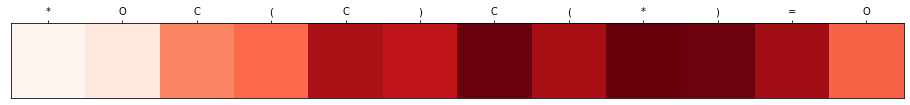

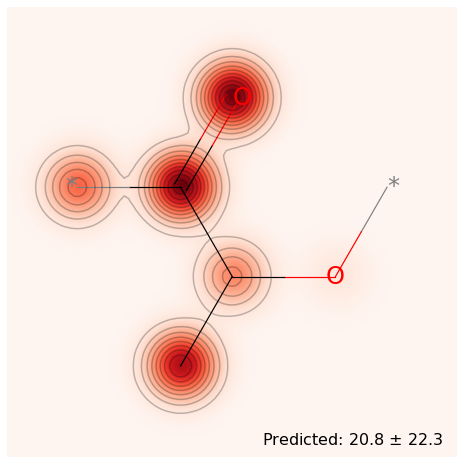

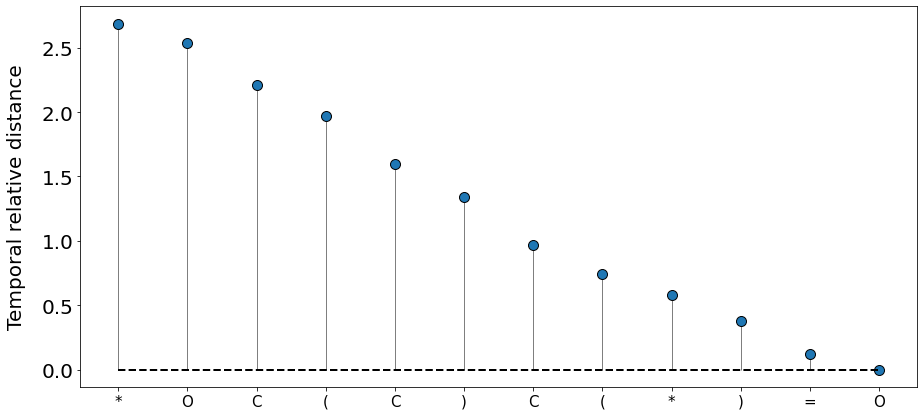

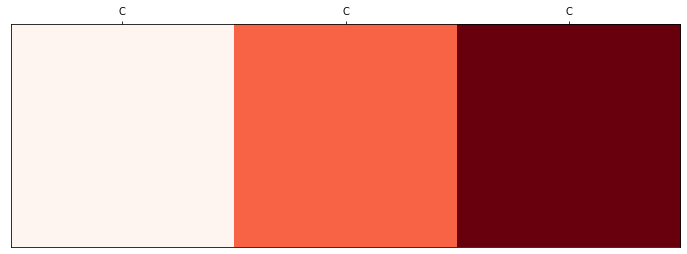

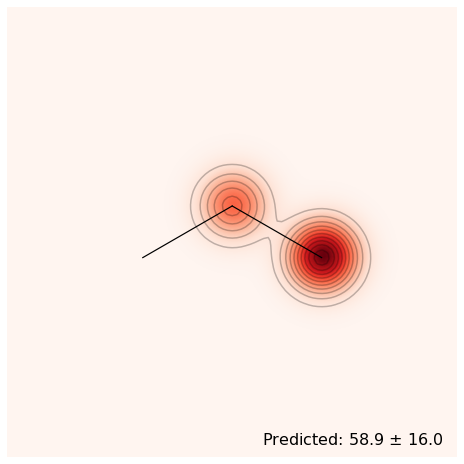

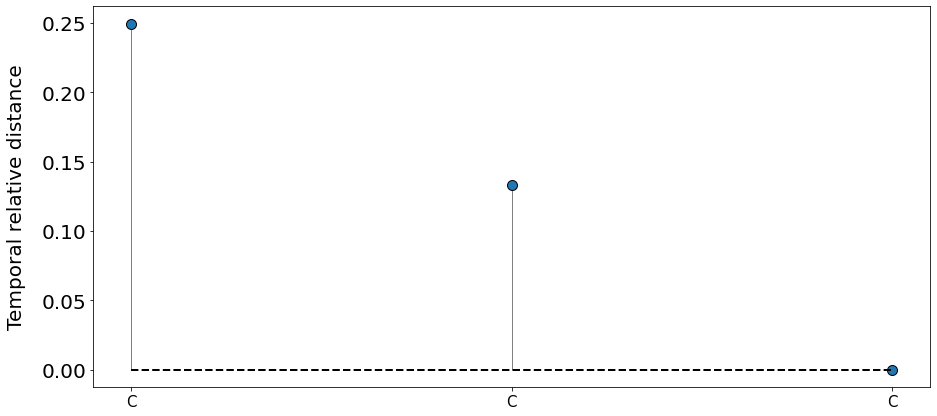

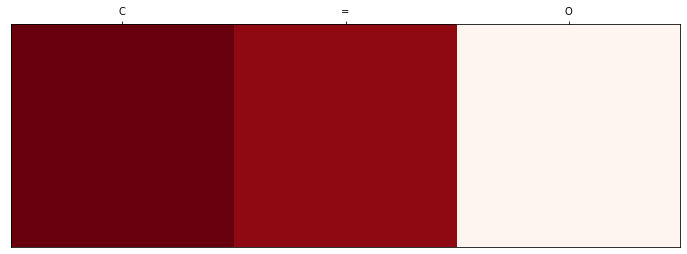

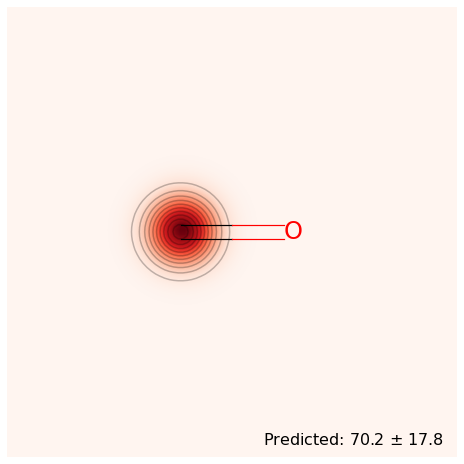

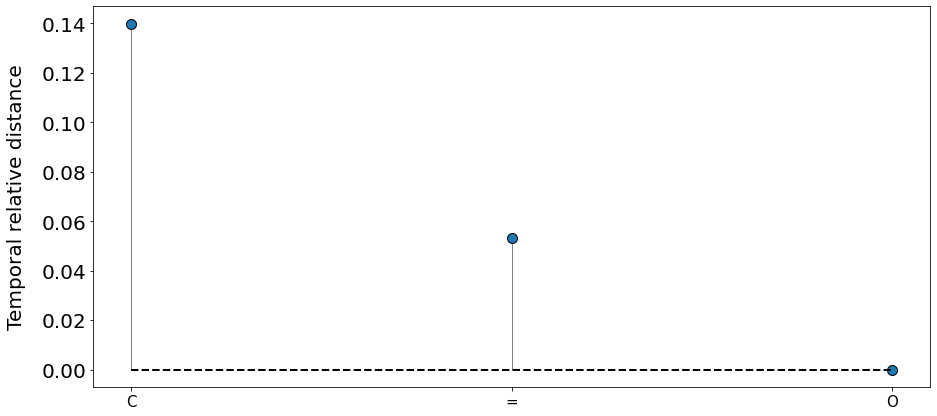

In [14]:
from SMILESX import interpret

inter = interpret.interpret(model=model,
                            smiles=preds['SMILES'],
                            pred=preds[['mean', 'sigma']],
                            check_smiles=True,
                            log_verbose=True)

Let us load models containing additional inputs. As the model is adjusted to take the additional inputs, they are also requested at the time of inference. For the same reason, temporal distance plot is not available for the models with additional inputs.

In [15]:
model = loadmodel.LoadModel(data_name = data_name+'_EXTRA',
                            augment = True, # Since the model was trained without augmentation
                            gpu_ind = 0,
                            return_attention = True)

1 Physical GPU(s), 1 Logical GPU(s) detected and configured.
1 GPU device(s) will be used.


All the required model files have been found.

*** MODELS LOADED ***


Note that data augmentation at the inference time can be requested regardless whether it was used for training or not. In this case, mean and standard deviation are computed over the augmentations and model ensemble.

In [16]:
preds = inference.infer(model=model,
                        data_smiles=['*OC(C)C(=O)*','CCC','C=O'],
                        data_extra=[[150,0.5,4], [87,0.2,15], [54,1.2,24]],
                        augment=True, # Since we want to augment the data before making inference
                        check_smiles=True,
                        log_verbose=True)

2023-05-22 10:57:30:   *************************************
2023-05-22 10:57:30:   ***   SMILESX INFERENCE STARTED   ***
2023-05-22 10:57:30:   *************************************
2023-05-22 10:57:30:   
2023-05-22 10:57:30:   Inference logs path:
2023-05-22 10:57:30:   ./outputs/Test_EXTRA/Augm/Inference/Augm/Inference_2023-05-22_10:57:30.log
2023-05-22 10:57:30:   
2023-05-22 10:57:30:   Full vocabulary: ['pad', 'unk', ')', 'C', ' ', '=', '(', '1', '2', 'O']
2023-05-22 10:57:30:   Vocabulary size: 10
2023-05-22 10:57:30:   Maximum length of tokenized SMILES: 27 tokens.

2023-05-22 10:57:30:   Number of enumerated SMILES: 11
2023-05-22 10:57:30:   
2023-05-22 10:57:30:   Tokenization of SMILES...
2023-05-22 10:57:33:   
2023-05-22 10:57:33:   Prediction results:
    SMILES          Prediction (mean)    Prediction (std)
--  ------------  -------------------  ------------------
 0  *OC(C)C(=O)*             -7.63065             2098.95
 1  CCC                      28.1599             

Let us create fake true values for the molecules we passed for the prediction, to see the values on the interpretation 2D figures.

In [17]:
import pandas as pd
# Fake ground truth values to show them 2D interpretation plots
trues = pd.DataFrame([[400, 370, 415],
                      [300, 280, 310],
                      [200, 190, 205]])
trues.columns = ['median', 'min', 'max']

Note the absence of temporal difference plots.

2023-05-22 10:57:33:   ******************************************
2023-05-22 10:57:33:   ***   SMILESX INTERPRETATION STARTED   ***
2023-05-22 10:57:33:   ******************************************
2023-05-22 10:57:33:   
2023-05-22 10:57:33:   Interpretation logs path:
2023-05-22 10:57:33:   ./outputs/Test_EXTRA/Augm/Interpret/Interpret_2023-05-22_10:57:33.log
2023-05-22 10:57:33:   
2023-05-22 10:57:33:   Full vocabulary: ['pad', 'unk', ')', 'C', ' ', '=', '(', '1', '2', 'O']
2023-05-22 10:57:33:   Vocabulary size: 10
2023-05-22 10:57:33:   Maximum length of tokenized SMILES: 27 tokens.

2023-05-22 10:57:37:   *******
2023-05-22 10:57:37:   SMILES: *OC(C)C(=O)*


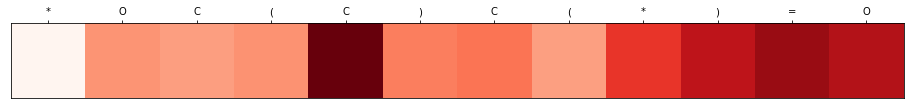

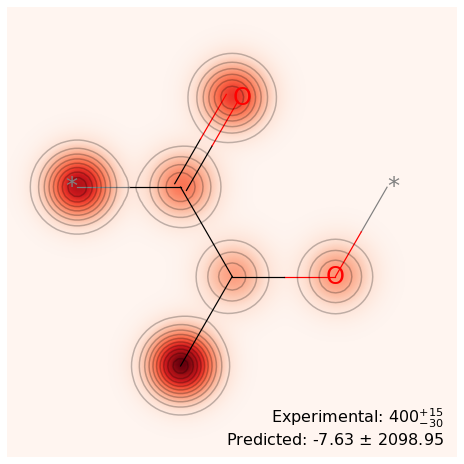

2023-05-22 10:57:38:   *******
2023-05-22 10:57:38:   SMILES: CCC


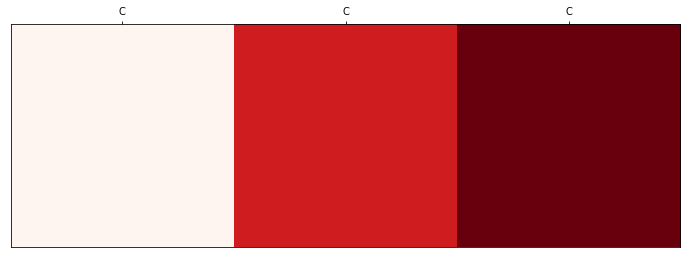

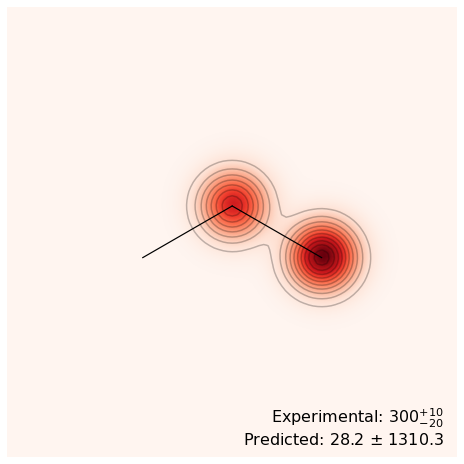

2023-05-22 10:57:39:   *******
2023-05-22 10:57:39:   SMILES: C=O


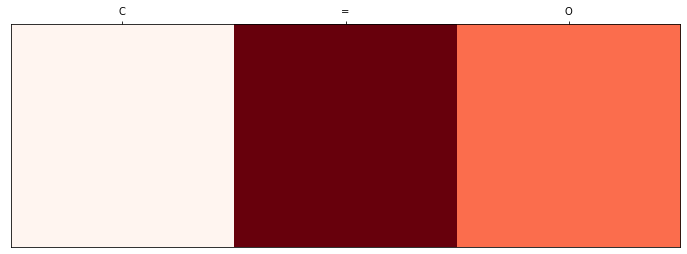

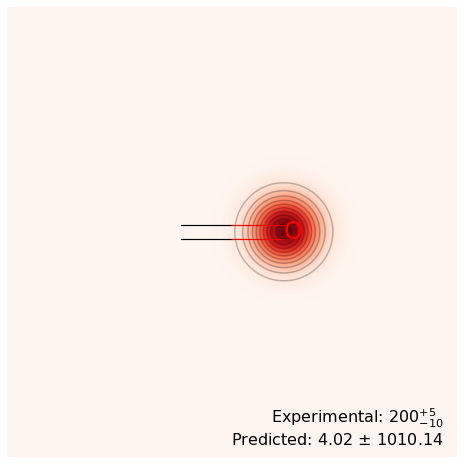

2023-05-22 10:57:39:   ********************************************
2023-05-22 10:57:39:   ***   SMILESX INTERPRETATION COMPLETED   ***
2023-05-22 10:57:39:   ********************************************


In [18]:
inter = interpret.interpret(model=model,
                            smiles=preds['SMILES'],
                            pred=preds[['mean', 'sigma']],
                            true=trues['median'],
                            true_err=trues[['min','max']],
                            check_smiles=True,
                            log_verbose=True)

### Molecular generation with SMILES-X

In [101]:
generation_class = generation.Generation(data_name = data_name, 
                                         g_run_number = 0, 
                                         gen_augmentation = True,
                                         infer_augmentation = True,
                                         indir = "./outputs", 
                                         outdir = "./outputs",
                                         n_gpus = 1)

The ./outputs/Test/LM/Augm/Train/Models directory contains 1 best generator model(s) with high CUN score.

No property to infer.

*************************************
***Molecular generation initiated.***
*************************************



In [108]:
n_generate = 1000

new_smiles_list = generation_class.generate(starter='', 
                                            n_generate = n_generate, 
                                            top_k = None, 
                                            batch_size = 8096)

In [109]:
len(new_smiles_list)

6

In [110]:
new_smiles_list

['CO',
 'COC(CO)C(C=O)C(O)C=O',
 'O=CC(O)C(O)C(O)C(CO)CO',
 'O=CC(CO)C1CC(O)OC(O)CC1O',
 'O',
 'CC(O)OCC(O)C1OC(O)C1OC(C)O']

In [111]:
n_generate = 10
sol_data = data[['smiles1']]

new_smiles_list_len = len(new_smiles_list)
correctness = (new_smiles_list_len/n_generate)
unique_smiles = np.unique(new_smiles_list)
uniqueness = unique_smiles.shape[0]/float(new_smiles_list_len)
novelty = len(set(unique_smiles).difference(set(sol_data['smiles1'].values.tolist())))/unique_smiles.shape[0]
print("C Score: {:0.2f}%".format(correctness*100.))
print("U Score: {:0.2f}%".format(uniqueness*100.))
print("N Score: {:0.2f}%".format(novelty*100.))
print("CUN (CxUxN) Score: {:0.2f}%\n".format(correctness * uniqueness * novelty * 100.))

C Score: 60.00%
U Score: 100.00%
N Score: 83.33%
CUN (CxUxN) Score: 50.00%



In [112]:
from SMILESX import loadmodel

# Load trained models once, use as many times as needed
model = loadmodel.LoadModel(data_name=data_name,
                            augment=False,
                            gpu_ind=0,
                            return_attention=True)

1 Physical GPU(s), 1 Logical GPU(s) detected and configured.
1 GPU device(s) will be used.


All the required model files have been found.

*** MODELS LOADED ***


Then, the loaded model instance can be used for inference and/or interpretation. 

In [113]:
from SMILESX import inference

preds = inference.infer(model=model,
                        data_smiles=new_smiles_list,
                        augment=True,
                        check_smiles=True,
                        log_verbose=True)

2023-10-31 15:01:16:   *************************************
2023-10-31 15:01:16:   ***   SMILESX INFERENCE STARTED   ***
2023-10-31 15:01:16:   *************************************
2023-10-31 15:01:16:   
2023-10-31 15:01:16:   Inference logs path:
2023-10-31 15:01:16:   ./outputs/Test/Can/Inference/Augm/Inference_2023-10-31_15:01:16.log
2023-10-31 15:01:16:   
2023-10-31 15:01:16:   model_type = 'regression'
2023-10-31 15:01:16:   Full vocabulary: ['pad', 'unk', '=', ' ', '2', '(', 'C', 'O', '1', ')']
2023-10-31 15:01:16:   Vocabulary size: 10
2023-10-31 15:01:16:   Maximum length of tokenized SMILES: 24 tokens.

2023-10-31 15:01:16:   Number of enumerated SMILES: 59
2023-10-31 15:01:16:   
2023-10-31 15:01:16:   Tokenization of SMILES...
2023-10-31 15:01:18:   
2023-10-31 15:01:18:   Prediction results:
    SMILES                        Prediction (mean)    Prediction (std)
--  --------------------------  -------------------  ------------------
 0  CO                               

In [114]:
preds

,SMILES,mean,sigma
0,CO,7.237958,7.423434
1,COC(CO)C(C=O)C(O)C=O,-40.478865,35.018162
2,O=CC(O)C(O)C(O)C(CO)CO,-43.695644,38.841679
3,O=CC(CO)C1CC(O)OC(O)CC1O,-41.315365,37.759292
4,O,15.194851,13.074323
5,CC(O)OCC(O)C1OC(O)C1OC(C)O,-40.250816,38.924861


#### With property constraints

In [158]:
generation_class = generation.Generation(data_name= data_name, 
                                         g_run_number = 0, 
                                         gen_augmentation = True,
                                         infer_augmentation = False,
                                         infer_use_n_folds = 1,
                                         infer_use_n_runs = 1,
                                         indir = "./outputs", 
                                         outdir = "./outputs",
                                         n_gpus = 1, 
                                         prop_names_list = ['Test'])

The ./outputs/Test/LM/Augm/Train/Models directory contains 1 best generator model(s) with high CUN score.

The ./outputs/Test/Can/Train/Models directory contains 4 predictor model(s).
The ./outputs/Test/Can/Train/Models directory contains 2-fold cross-validation.
The ./outputs/Test/Can/Train/Models directory contains 2 runs per fold.

1 fold(s) and 1 run(s) will be used for each property inference on request.


All the required model files have been found.

*** MODELS LOADED ***
*************************************
***Molecular generation initiated.***
*************************************



In [160]:
n_generate = 100

new_smiles_list = generation_class.generate(starter='', 
                                            n_generate = n_generate, 
                                            top_k = None, 
                                            batch_size = 8096, 
                                            bounds_list = [(5,15)],
                                            tolerance = 5, 
                                            prop_gamma_list = [1.], 
                                            prior_gamma= 1.)

In [155]:
len(new_smiles_list)

0

In [156]:
new_smiles_list

[]

In [148]:
sol_data = data[['smiles1']]

new_smiles_list_len = len(new_smiles_list)
correctness = (new_smiles_list_len/n_generate)
unique_smiles = np.unique(new_smiles_list)
uniqueness = unique_smiles.shape[0]/float(new_smiles_list_len)
novelty = len(set(unique_smiles).difference(set(sol_data['smiles1'].values.tolist())))/unique_smiles.shape[0]
print("C Score: {:0.2f}%".format(correctness*100.))
print("U Score: {:0.2f}%".format(uniqueness*100.))
print("N Score: {:0.2f}%".format(novelty*100.))
print("CUN (CxUxN) Score: {:0.2f}%\n".format(correctness * uniqueness * novelty * 100.))

C Score: 1.50%
U Score: 26.67%
N Score: 100.00%
CUN (CxUxN) Score: 0.40%



In [149]:
from SMILESX import loadmodel

# Load trained models once, use as many times as needed
model = loadmodel.LoadModel(data_name=data_name,
                            augment=False,
                            gpu_ind=0,
                            return_attention=True)

1 Physical GPU(s), 1 Logical GPU(s) detected and configured.
1 GPU device(s) will be used.


All the required model files have been found.

*** MODELS LOADED ***


Then, the loaded model instance can be used for inference and/or interpretation. 

In [150]:
from SMILESX import inference

preds = inference.infer(model=model,
                        data_smiles=new_smiles_list,
                        augment=True,
                        check_smiles=True,
                        log_verbose=True)

2023-11-01 09:53:32:   *************************************
2023-11-01 09:53:32:   ***   SMILESX INFERENCE STARTED   ***
2023-11-01 09:53:32:   *************************************
2023-11-01 09:53:32:   
2023-11-01 09:53:32:   Inference logs path:
2023-11-01 09:53:32:   ./outputs/Test/Can/Inference/Augm/Inference_2023-11-01_09:53:32.log
2023-11-01 09:53:32:   
2023-11-01 09:53:32:   model_type = 'regression'
2023-11-01 09:53:32:   Full vocabulary: ['pad', 'unk', '=', ' ', '2', '(', 'C', 'O', '1', ')']
2023-11-01 09:53:32:   Vocabulary size: 10
2023-11-01 09:53:32:   Maximum length of tokenized SMILES: 24 tokens.

2023-11-01 09:53:32:   Number of enumerated SMILES: 57
2023-11-01 09:53:32:   
2023-11-01 09:53:32:   Tokenization of SMILES...
2023-11-01 09:53:34:   
2023-11-01 09:53:34:   Prediction results:
    SMILES                        Prediction (mean)    Prediction (std)
--  --------------------------  -------------------  ------------------
 0  O                                

In [151]:
preds

,SMILES,mean,sigma
0,O,15.194851,13.074323
1,O,15.194851,13.074323
2,O,15.194851,13.074323
3,O,15.194851,13.074323
4,O,15.194851,13.074323
5,O,15.194851,13.074323
6,OC1OCC(O)C(O)C(C(O)O)O1,-38.042439,40.400977
7,O,15.194851,13.074323
8,O,15.194851,13.074323
9,O,15.194851,13.074323
